In [1]:
# (token方向に)AvgPool -> (embed方向に)LayerNorm

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='018'
    debug=False  # False
    wandb=True
    resume= None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Wed Jun  8 06:24:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 53.9 ms, sys: 36.4 ms, total: 90.4 ms
Wall time: 3.23 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        # id='3bwalqa8',
                        anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [12]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

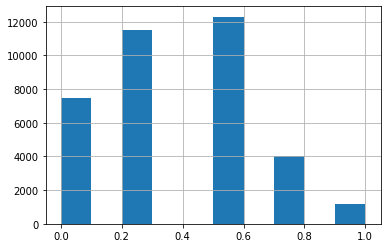

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
                
        return output

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     if checkpoint['epoch'] < CFG.epochs-1:  # foldの終わりで止まっている時もある
    #         model.load_state_dict(checkpoint['model'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         scheduler.load_state_dict(checkpoint['scheduler'])
    #         # amp.load_state_dict(checkpoint['amp'])
    #         epoch = checkpoint['epoch'] + 1  # 保存時のエポックが読み出されるので+1
    #         best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/1725] Elapsed 0m 1s (remain 37m 28s) Loss: 0.7255(0.7255) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 20s (remain 21m 39s) Loss: 0.5259(0.6327) Grad: 15220.7285  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 40s (remain 20m 13s) Loss: 0.6178(0.6139) Grad: 19759.1230  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 3m 59s (remain 18m 51s) Loss: 0.4391(0.6048) Grad: 12368.8535  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 5m 18s (remain 17m 31s) Loss: 0.6132(0.5994) Grad: 39468.8438  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 6m 37s (remain 16m 10s) Loss: 0.6080(0.5921) Grad: 11136.7148  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 7m 56s (remain 14m 51s) Loss: 0.4828(0.5874) Grad: 5275.4209  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 9m 15s (remain 13m 32s) Loss: 0.6343(0.5828) Grad: 40839.6328  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 10m 35s (remain 12m 12s) Loss: 0.5768(0.5804) Grad: 9096.6582  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed 1

Epoch 1 - avg_train_loss: 0.5680  avg_val_loss: 0.5578  time: 1480s
Epoch 1 - Score: 0.8061
Epoch 1 - Save Best Score: 0.8061 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 44m 40s) Loss: 0.6451(0.6451) Grad: inf  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 25s (remain 22m 50s) Loss: 0.5277(0.5244) Grad: 67600.0078  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 2m 45s (remain 20m 55s) Loss: 0.5977(0.5213) Grad: 114388.4375  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 4s (remain 19m 17s) Loss: 0.7195(0.5238) Grad: 143605.6094  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 5m 23s (remain 17m 49s) Loss: 0.6074(0.5219) Grad: 14218.6436  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 6m 42s (remain 16m 23s) Loss: 0.4407(0.5212) Grad: 109816.1172  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 8m 1s (remain 15m 0s) Loss: 0.5042(0.5193) Grad: 20726.4219  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 9m 20s (remain 13m 38s) Loss: 0.5004(0.5207) Grad: 19312.8750  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 10m 39s (remain 12m 17s) Loss: 0.4656(0.5189) Grad: 57875.5898  LR: 0.00001409  
Epoch: [2][900/1725] Elapsed

Epoch 2 - avg_train_loss: 0.5182  avg_val_loss: 0.5520  time: 1484s
Epoch 2 - Score: 0.8219


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.4983(0.5520) 


Epoch 2 - Save Best Score: 0.8219 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 40m 38s) Loss: 0.5001(0.5001) Grad: 48725.4258  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 24s (remain 22m 37s) Loss: 0.5350(0.4998) Grad: 36576.2500  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 2m 44s (remain 20m 47s) Loss: 0.4616(0.5017) Grad: 127280.0781  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 3s (remain 19m 12s) Loss: 0.5057(0.5038) Grad: 125663.7109  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 5m 22s (remain 17m 45s) Loss: 0.3972(0.5020) Grad: 77369.0391  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 6m 41s (remain 16m 21s) Loss: 0.5674(0.5009) Grad: 69049.2031  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 8m 0s (remain 14m 58s) Loss: 0.5058(0.5012) Grad: 89591.0234  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 9m 19s (remain 13m 37s) Loss: 0.5064(0.5033) Grad: 72189.1016  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 10m 39s (remain 12m 17s) Loss: 0.4984(0.5021) Grad: 112340.6484  LR: 0.00000644  
Epoch: [3][900/1725]

Epoch 3 - avg_train_loss: 0.5033  avg_val_loss: 0.5657  time: 1484s
Epoch 3 - Score: 0.8221
Epoch 3 - Save Best Score: 0.8221 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 46m 13s) Loss: 0.5381(0.5381) Grad: 31725.6992  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 25s (remain 22m 49s) Loss: 0.5952(0.5041) Grad: 73924.4688  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 2m 46s (remain 21m 1s) Loss: 0.4639(0.5005) Grad: 40581.0703  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 5s (remain 19m 21s) Loss: 0.4124(0.4985) Grad: 79588.0078  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 5m 24s (remain 17m 51s) Loss: 0.4423(0.4981) Grad: 68553.5391  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 6m 43s (remain 16m 26s) Loss: 0.5069(0.4990) Grad: 130297.0547  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 8m 2s (remain 15m 3s) Loss: 0.4945(0.4996) Grad: 27814.2988  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 9m 22s (remain 13m 41s) Loss: 0.4955(0.4998) Grad: 50091.8789  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 10m 41s (remain 12m 19s) Loss: 0.6160(0.4988) Grad: 78133.8047  LR: 0.00000088  
Epoch: [4][900/1725] Ela

Epoch 4 - avg_train_loss: 0.4980  avg_val_loss: 0.5683  time: 1486s
Epoch 4 - Score: 0.8214


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.4950(0.5683) 


========== fold: 1 result ==========
Score: 0.8221
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 44m 2s) Loss: 0.7046(0.7046) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 26s (remain 23m 18s) Loss: 0.6075(0.6346) Grad: 21230.8184  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 45s (remain 21m 5s) Loss: 0.4969(0.6127) Grad: 8447.4033  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 4m 4s (remain 19m 28s) Loss: 0.5061(0.6021) Grad: 16088.0010  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 5m 23s (remain 18m 0s) Loss: 0.5149(0.5918) Grad: 10908.9873  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 6m 46s (remain 16m 44s) Loss: 0.6263(0.5860) Grad: 22722.8145  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 8m 5s (remain 15m 20s) Loss: 0.5683(0.5816) Grad: 7648.9326  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 9m 24s (remain 13m 58s) Loss: 0.6606(0.5760) Grad: 21446.5273  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 10m 43s (remain 12m 35s) Loss: 0.6906(0.5721) Grad: 33705.7500  LR: 0.00001935  
Epoch: [1][900/1741] Elapsed 12m 3s

Epoch 1 - avg_train_loss: 0.5607  avg_val_loss: 0.5379  time: 1499s
Epoch 1 - Score: 0.8349


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.4138(0.5379) 


Epoch 1 - Save Best Score: 0.8349 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 44m 47s) Loss: 0.5513(0.5513) Grad: 108434.5938  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 24s (remain 22m 55s) Loss: 0.4357(0.5115) Grad: 120720.2344  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 2m 45s (remain 21m 6s) Loss: 0.5140(0.5188) Grad: 39864.9102  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 4s (remain 19m 30s) Loss: 0.5039(0.5197) Grad: 38576.6953  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 5m 23s (remain 18m 1s) Loss: 0.4649(0.5185) Grad: 85696.8438  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 6m 42s (remain 16m 36s) Loss: 0.5466(0.5191) Grad: 80347.0547  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 8m 1s (remain 15m 13s) Loss: 0.5530(0.5190) Grad: 34004.6797  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 9m 21s (remain 13m 52s) Loss: 0.5883(0.5189) Grad: 104504.0234  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 10m 40s (remain 12m 31s) Loss: 0.3849(0.5192) Grad: 43011.6836  LR: 0.00001412  
Epoch: [2][900/1741] E

Epoch 2 - avg_train_loss: 0.5179  avg_val_loss: 0.5388  time: 1495s
Epoch 2 - Score: 0.8442


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3695(0.5388) 


Epoch 2 - Save Best Score: 0.8442 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 42m 8s) Loss: 0.4536(0.4536) Grad: 63843.6953  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 23s (remain 22m 42s) Loss: 0.3827(0.5028) Grad: 99622.6953  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 2m 44s (remain 21m 1s) Loss: 0.6672(0.5057) Grad: 148412.6719  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 3s (remain 19m 25s) Loss: 0.6249(0.5106) Grad: 84139.5234  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 5m 22s (remain 17m 58s) Loss: 0.4623(0.5115) Grad: 66634.3906  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 6m 41s (remain 16m 34s) Loss: 0.5750(0.5111) Grad: 196049.4062  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 8m 0s (remain 15m 12s) Loss: 0.4996(0.5103) Grad: 74028.7422  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 9m 19s (remain 13m 50s) Loss: 0.5476(0.5107) Grad: 152684.4688  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 10m 39s (remain 12m 29s) Loss: 0.4068(0.5093) Grad: 54378.4766  LR: 0.00000647  
Epoch: [3][900/1741] E

Epoch 3 - avg_train_loss: 0.5061  avg_val_loss: 0.5441  time: 1494s


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3646(0.5441) 


Epoch 3 - Score: 0.8441


Epoch: [4][0/1741] Elapsed 0m 1s (remain 38m 35s) Loss: 0.5273(0.5273) Grad: 262029.2344  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 24s (remain 22m 56s) Loss: 0.5355(0.5128) Grad: 177627.2812  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 2m 44s (remain 20m 57s) Loss: 0.3130(0.5055) Grad: 20129.7871  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 4m 3s (remain 19m 23s) Loss: 0.5437(0.5036) Grad: 57431.0312  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 5m 22s (remain 17m 57s) Loss: 0.4656(0.5039) Grad: 180500.0312  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 6m 41s (remain 16m 33s) Loss: 0.4434(0.5039) Grad: 34185.2617  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 8m 0s (remain 15m 11s) Loss: 0.4298(0.5037) Grad: 33283.8633  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 9m 19s (remain 13m 50s) Loss: 0.4486(0.5012) Grad: 63037.2773  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 10m 38s (remain 12m 29s) Loss: 0.4743(0.5012) Grad: 27207.2129  LR: 0.00000089  
Epoch: [4][900/1741]

Epoch 4 - avg_train_loss: 0.5014  avg_val_loss: 0.5465  time: 1494s
Epoch 4 - Score: 0.8429


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3569(0.5465) 


========== fold: 2 result ==========
Score: 0.8442
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 42m 23s) Loss: 0.7435(0.7435) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 24s (remain 21m 58s) Loss: 0.5645(0.6182) Grad: 15890.5342  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 2m 43s (remain 20m 1s) Loss: 0.6001(0.6032) Grad: 18343.2637  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 4m 2s (remain 18m 29s) Loss: 0.6000(0.5923) Grad: 8806.1377  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 5m 21s (remain 17m 4s) Loss: 0.6444(0.5823) Grad: 14587.5078  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 6m 40s (remain 15m 42s) Loss: 0.4434(0.5768) Grad: 19541.3203  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 8m 0s (remain 14m 20s) Loss: 0.5497(0.5715) Grad: 31053.9277  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 9m 19s (remain 12m 59s) Loss: 0.6001(0.5681) Grad: 14954.9609  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 10m 38s (remain 11m 39s) Loss: 0.4608(0.5643) Grad: 4153.2168  LR: 0.00001931  
Epoch: [1][900/1678] Elapsed 11m 5

Epoch 1 - avg_train_loss: 0.5551  avg_val_loss: 0.5584  time: 1457s
Epoch 1 - Score: 0.7966
Epoch 1 - Save Best Score: 0.7966 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 48m 2s) Loss: 0.5675(0.5675) Grad: 68493.7969  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 26s (remain 22m 38s) Loss: 0.5660(0.5300) Grad: 22817.0586  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 2m 46s (remain 20m 25s) Loss: 0.4634(0.5220) Grad: 33774.6758  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 4m 5s (remain 18m 44s) Loss: 0.5222(0.5194) Grad: 11795.8164  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 5m 24s (remain 17m 14s) Loss: 0.5830(0.5187) Grad: 68537.6797  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 6m 43s (remain 15m 49s) Loss: 0.5721(0.5181) Grad: 50935.5352  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 8m 3s (remain 14m 25s) Loss: 0.4970(0.5161) Grad: 12330.3252  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 9m 22s (remain 13m 3s) Loss: 0.5612(0.5166) Grad: 17209.4297  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 10m 41s (remain 11m 42s) Loss: 0.3827(0.5169) Grad: 33674.7266  LR: 0.00001399  
Epoch: [2][900/1678] Elap

Epoch 2 - avg_train_loss: 0.5149  avg_val_loss: 0.5518  time: 1460s
Epoch 2 - Score: 0.8130
Epoch 2 - Save Best Score: 0.8130 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 36m 36s) Loss: 0.5823(0.5823) Grad: 90468.6562  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 24s (remain 21m 51s) Loss: 0.6042(0.5014) Grad: 110865.5312  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 2m 45s (remain 20m 17s) Loss: 0.5436(0.5025) Grad: 787861.9375  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 4m 5s (remain 18m 41s) Loss: 0.5163(0.5009) Grad: 45717.1172  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 5m 24s (remain 17m 12s) Loss: 0.5162(0.4993) Grad: 84668.6719  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 6m 43s (remain 15m 47s) Loss: 0.5199(0.4991) Grad: 49356.8359  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 8m 2s (remain 14m 24s) Loss: 0.3426(0.5023) Grad: 27975.2695  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 9m 21s (remain 13m 2s) Loss: 0.6044(0.5013) Grad: 67436.8125  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 10m 40s (remain 11m 41s) Loss: 0.5471(0.5016) Grad: 191684.7500  LR: 0.00000634  
Epoch: [3][900/1678] 

Epoch 3 - avg_train_loss: 0.5024  avg_val_loss: 0.5590  time: 1459s
Epoch 3 - Score: 0.8129


Epoch: [4][0/1678] Elapsed 0m 1s (remain 35m 41s) Loss: 0.5305(0.5305) Grad: 49254.5898  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 23s (remain 21m 46s) Loss: 0.4434(0.4977) Grad: 420483.2500  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 2m 43s (remain 19m 58s) Loss: 0.5193(0.4985) Grad: 33104.2227  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 4m 2s (remain 18m 27s) Loss: 0.4164(0.4980) Grad: 19948.6387  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 5m 21s (remain 17m 3s) Loss: 0.5513(0.4957) Grad: 88212.3594  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 6m 40s (remain 15m 40s) Loss: 0.4716(0.4966) Grad: 50293.9961  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 7m 59s (remain 14m 19s) Loss: 0.5019(0.4974) Grad: 79560.6641  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 9m 18s (remain 12m 58s) Loss: 0.4954(0.4985) Grad: 132099.1719  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 10m 37s (remain 11m 38s) Loss: 0.5360(0.4988) Grad: 26985.0195  LR: 0.00000083  
Epoch: [4][900/1678] 

Epoch 4 - avg_train_loss: 0.4975  avg_val_loss: 0.5668  time: 1456s
Epoch 4 - Score: 0.8117
========== fold: 3 result ==========
Score: 0.8130
========== CV ==========
Score: 0.8281


[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▄▁▇█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▇▇▆▆▆█▆▇▇▄▄▇▅▆▇▄▃▂▅▃▅▃▁▆▅▆▂▅▇▅▃▄▅▅▃▆▃▅▅
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold1] score,▁███
[fold2] avg_train_loss,█▃▂▁
[fold2] avg_val_loss,▁▂▆█
[fold2] epoch,▁▃▆█
[fold2] loss,▆▅▄▅█▅█▅▇▃▂▇▄▅▂▆▂▃▂▄▅▄▆▆▂▃▄▁▆▅▃▃▅▂▂▃▅▂▃▂
[fold2] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [25]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,text,text_rev,fold,pred
5403,79880cebf94c4860,mentioned conveyor,metal injection molded suture needles,B22,0.25,PERFORMING OPERATIONS. TRANSPORTING. CASTING. ...,mentioned conveyor. [SEP] metal injection mold...,metal injection molded suture needles. [SEP] m...,0,0.157614
19990,83077b9157bde9bd,cyclic alcohols,cyclopentanol,C10,0.50,"HEMISTRY. METALLURGY. PETROLEUM, GAS OR COKE I...",cyclic alcohols. [SEP] cyclopentanol. [SEP] HE...,cyclopentanol. [SEP] cyclic alcohols. [SEP] HE...,2,0.520113
28930,ea38794cfb4e92bb,dimensional location,dimension,F41,0.50,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,dimensional location. [SEP] dimension. [SEP] M...,dimension. [SEP] dimensional location. [SEP] M...,3,0.496434
35797,65bad31720aa46af,use voltage converter,race circuit,F02,0.00,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,use voltage converter. [SEP] race circuit. [SE...,race circuit. [SEP] use voltage converter. [SE...,3,0.001102
28417,8933b87a080c1a1b,composite tile,metallurgical furnace part,F27,0.50,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,composite tile. [SEP] metallurgical furnace pa...,metallurgical furnace part. [SEP] composite ti...,3,0.322452
15166,37129ef60da0e308,ply tire,plymouth,B29,0.00,PERFORMING OPERATIONS. TRANSPORTING. WORKING O...,ply tire. [SEP] plymouth. [SEP] PERFORMING OPE...,plymouth. [SEP] ply tire. [SEP] PERFORMING OPE...,1,0.000423
19014,5e0dbb7340a1b260,based method,measurement type,G01,0.25,PHYSICS. MEASURING. TESTING,based method. [SEP] measurement type. [SEP] PH...,measurement type. [SEP] based method. [SEP] PH...,2,0.365913
10805,ff7aef2cf3b54d3b,channel vectors,channel weight vector,H04,0.50,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,channel vectors. [SEP] channel weight vector. ...,channel weight vector. [SEP] channel vectors. ...,1,0.552594
7823,5e1b1c4c7cdc2002,source channel,source codes,B05,0.00,PERFORMING OPERATIONS. TRANSPORTING. SPRAYING ...,source channel. [SEP] source codes. [SEP] PERF...,source codes. [SEP] source channel. [SEP] PERF...,0,0.000229
31989,2b55f603b2d0d0fa,mat sections,tubes,A01,0.25,HUMAN NECESSITIES. GRICULTURE. FORESTRY. ANIMA...,mat sections. [SEP] tubes. [SEP] HUMAN NECESSI...,tubes. [SEP] mat sections. [SEP] HUMAN NECESSI...,3,0.262365


In [26]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:02<00:00, 6.65kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:03<00:00, 758kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:49<00:00, 34.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:03<00:00, 786B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:35<00:00, 48.5MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file train.log
100% 2.78k/2.78k [00:03<00:00, 829B/s]
Upload successful: train.log (3KB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:35<00:00, 48.3MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload f